In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset

In [2]:
df = pd.read_csv('Fraud_data/Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
# Separate the fraud and non-fraud cases
df_fraud = df[df.isFraud == 1]
df_non_fraud = df[df.isFraud == 0]

# Perform undersampling on the non-fraud cases
df_non_fraud_undersampled = df_non_fraud.sample(n=len(df_fraud) + 5000, random_state=42)

# Combine the fraud cases with the undersampled non-fraud cases
df_balanced = pd.concat([df_fraud, df_non_fraud_undersampled])

# Shuffle the resulting balanced DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
df_balanced.isFraud.value_counts()

isFraud
0    13213
1     8213
Name: count, dtype: int64

In [7]:


# Encode categorical variables
label_encoder = LabelEncoder()
df_balanced['type'] = label_encoder.fit_transform(df_balanced['type'])
df_balanced['nameOrig'] = label_encoder.fit_transform(df_balanced['nameOrig'])
df_balanced['nameDest'] = label_encoder.fit_transform(df_balanced['nameDest'])

# Fill missing values
df_balanced['oldbalanceDest'].fillna(0, inplace=True)
df_balanced['newbalanceDest'].fillna(0, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','nameOrig','nameDest']
df_balanced[numerical_features] = scaler.fit_transform(df_balanced[numerical_features])

# Define features and target
features = df_balanced.drop(columns=['isFraud', 'isFlaggedFraud',"step"])
target = df_balanced['isFraud']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert to numpy arrays for easier handling
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values


C:\Users\amoha\AppData\Local\Temp\ipykernel_21936\979282634.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_balanced['oldbalanceDest'].fillna(0, inplace=True)
C:\Users\amoha\AppData\Local\Temp\ipykernel_21936\979282634.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class FraudDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

class FraudDetectionModel(nn.Module):
    def __init__(self, num_numerical_features, num_types, embedding_dim=32):
        super(FraudDetectionModel, self).__init__()
        self.type_embedding = nn.Embedding(num_types, embedding_dim)
        
        self.fc1 = nn.Linear(17, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        type_embedded = self.type_embedding(x[:, 0].long())

        
        x_numerical = x[:, [ 1,2, 3,4, 5, 6,7]]
        
        x = torch.cat([x_numerical, type_embedded], dim=1)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x


In [9]:
# Number of unique values for embeddings
num_types = df_balanced['type'].nunique()


# Prepare datasets and dataloaders
train_dataset = FraudDataset(X_train, y_train)
test_dataset = FraudDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# Ensure CUDA is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move model to the device (GPU)
model = FraudDetectionModel(num_numerical_features=9, 
    num_types=num_types, 
    embedding_dim=10).to(device)
model

Using device: cuda


FraudDetectionModel(
  (type_embedding): Embedding(5, 10)
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
total_param = 0
for param in model.parameters():
    print(param.size())
    total_param+=len(param)
print(total_param)

torch.Size([5, 10])
torch.Size([64, 17])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
199


In [12]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader)}')



c:\Users\amoha\anaconda3\envs\cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/10, Loss: 0.3975636393610221
Epoch 2/10, Loss: 0.2556215113779502
Epoch 3/10, Loss: 0.2255949360777193
Epoch 4/10, Loss: 0.21179726047079955
Epoch 5/10, Loss: 0.2021458623235795
Epoch 6/10, Loss: 0.19358575652673174
Epoch 7/10, Loss: 0.1831412725428592
Epoch 8/10, Loss: 0.1723434770090589
Epoch 9/10, Loss: 0.16672363632650516
Epoch 10/10, Loss: 0.1581360881508731


ROC AUC: 0.987395086150053
Precision: 0.9278668310727497
Recall: 0.9060806742925949
F1 Score: 0.9168443496801707
Confusion Matrix:
[[2508  117]
 [ 156 1505]]
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2625
         1.0       0.93      0.91      0.92      1661

    accuracy                           0.94      4286
   macro avg       0.93      0.93      0.93      4286
weighted avg       0.94      0.94      0.94      4286



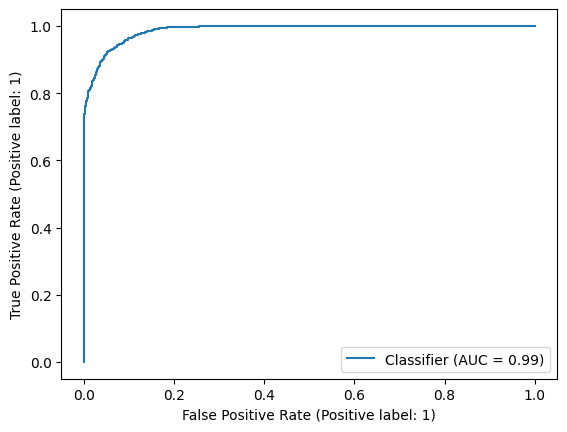

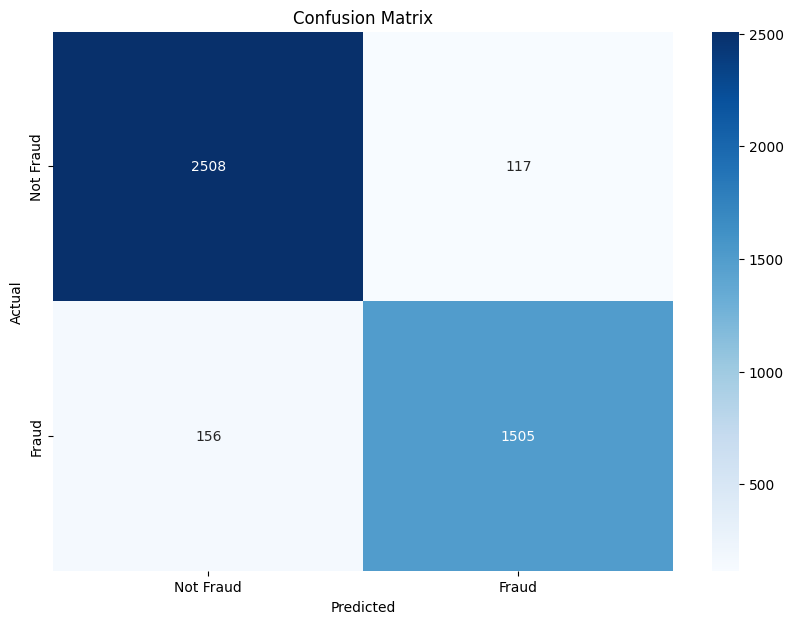

In [14]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Metrics
roc_auc = roc_auc_score(all_labels, all_probs)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"ROC AUC: {roc_auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print(classification_report(all_labels, all_preds))

# ROC Curve
RocCurveDisplay.from_predictions(all_labels, all_probs)
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Save the model
model_path = 'Models/fraud_detection_deep_model_0.94ac.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to Models/fraud_detection_deep_model_0.94ac.pth


In [24]:
torch.cuda.is_available()

True

In [16]:
# Load the model
model2 = FraudDetectionModel(
    num_numerical_features=7, 
    num_types=num_types, 
    embedding_dim=10
)
model2.load_state_dict(torch.load(model_path))

print("Model loaded successfully")


Model loaded successfully
